In [ ]:
# Setup
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# imports
sys.path.append(os.path.abspath(".."))
from answer_categories import question_orders
from lists import comparison_pairs_by_AI_questions, single_choice_questions, multiple_choice_questions
from Helper_funtions import (
    calculate_true_false_score,
    clean_up_subjects,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding
)

# load excel
file_path = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df =  pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# reduce nr of subjects to a max of 3
df = clean_up_subjects(df, "Most used subjects")

# Calculate True/False score and add to DataFrame
df = calculate_true_false_score(df)

# Calculate the score
df = calculate_Internet_terms_understanding_score(df)

df = group_internet_understanding(df)

for demo, question_list in comparison_pairs_by_AI_questions.items(): 
    for question in question_list:

        try:
            if question in multiple_choice_questions:
                exploded_df = (
                    df[[demo, question]]
                    .dropna()
                    .assign(**{question: df[question].str.split(",")})
                    .explode(question)
                )
                exploded_df[question] = exploded_df[question].str.strip()
                data = exploded_df
            elif question in single_choice_questions:
                data = df[[demo, question]].dropna()
                data = data[data[question].astype(str).str.strip() != ""]
            else:
                continue  # Weder Single noch Multiple
            
            # Crosstab normalized by row (percentages)
            cross = pd.crosstab(data[demo], data[question], normalize='index') * 100

            # Use predefined order if available
            if question in question_orders:
                order = question_orders[question]
                for col in order:
                    if col not in cross.columns:
                        cross[col] = 0
                cross = cross[order]
            
            # Optional: sort numeric demographic column
            if pd.api.types.is_numeric_dtype(df[demo]):
                cross = cross.sort_index()

            print(f"\n📊 {question} grouped by {demo}")
            print(cross.round(1).to_string())

            # Plot as graph
            plot_df = cross.reset_index().melt(id_vars=demo, var_name="Answer", value_name="Percentage")

            plt.figure(figsize=(10, 6))
            sns.barplot(data=plot_df, x="Answer", y="Percentage", hue=demo)

            plt.title(f"{question} grouped by {demo}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"❌ Test failed for {question} x {demo}: {e}")


In [ ]:
# Setup
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# imports
sys.path.append(os.path.abspath(".."))
from answer_categories import question_orders
from lists import comparison_pairs_by_AI_questions, single_choice_questions, multiple_choice_questions
from Helper_funtions import (
    calculate_true_false_score,
    clean_up_subjects,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding
)

# load excel
file_path = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df =  pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# reduce nr of subjects to a max of 3
df = clean_up_subjects(df, "Most used subjects")

# Calculate True/False score and add to DataFrame
df = calculate_true_false_score(df)

# Calculate the score
df = calculate_Internet_terms_understanding_score(df)

df = group_internet_understanding(df)


for demo, question_list in comparison_pairs_by_AI_questions.items(): 
    for question in question_list:
        try:
            relevant_cols = [demo, question]
            data = df[relevant_cols].dropna()

            # Handle exploding if any of the two is multiple choice
            for col in relevant_cols:
                if col in multiple_choice_questions:
                    data[col] = data[col].astype(str).str.split(",")
                    data = data.explode(col)
                    data[col] = data[col].str.strip()

            # Drop any remaining empty entries
            data = data.dropna()
            data = data[(data[demo].astype(str).str.strip() != "") & (data[question].astype(str).str.strip() != "")]

            # Crosstab normalized by row (percentages)
            cross = pd.crosstab(data[demo], data[question], normalize='index') * 100

            # Apply predefined order
            if question in question_orders:
                order = question_orders[question]
                for col in order:
                    if col not in cross.columns:
                        cross[col] = 0
                cross = cross[order]

            if pd.api.types.is_numeric_dtype(data[demo]):
                cross = cross.sort_index()

            print(f"\n📊 {question} grouped by {demo}")
            print(cross.round(1).to_string())

            # Plot
            plot_df = cross.reset_index().melt(id_vars=demo, var_name="Answer", value_name="Percentage")

            plt.figure(figsize=(10, 6))
            sns.barplot(data=plot_df, x="Answer", y="Percentage", hue=demo)
            plt.title(f"{question} grouped by {demo}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Test failed for {question} x {demo}: {e}")


c:\Users\tills\Bachelor-Code\Analyse_Files\Helper_funtions.py:124: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df[internet_cols].replace(Internet_terms_mapping)



🔍 Chi²-test: Use AI school and freetime × Usefullness AI | chi²=88.460, df=9, p=0.0000 → ✅ significant

📊 Usefullness AI within each Use AI school and freetime (rows sum to 100%)
Counts:
 Usefullness AI              Sehr nützlich  Ziemlich nützlich  Teils/teils  \
Use AI school and freetime                                                  
Täglich                                42                 13            1   
Mehrmals pro Woche                     20                 29           19   
Etwa 1 Mal pro Woche                    3                 21           12   
Seltener                                0                 10           19   

Usefullness AI              Wenig nützlich  
Use AI school and freetime                  
Täglich                                  0  
Mehrmals pro Woche                       0  
Etwa 1 Mal pro Woche                     2  
Seltener                                 2  

Percent:
 Usefullness AI              Sehr nützlich  Ziemlich nützlich  Teils

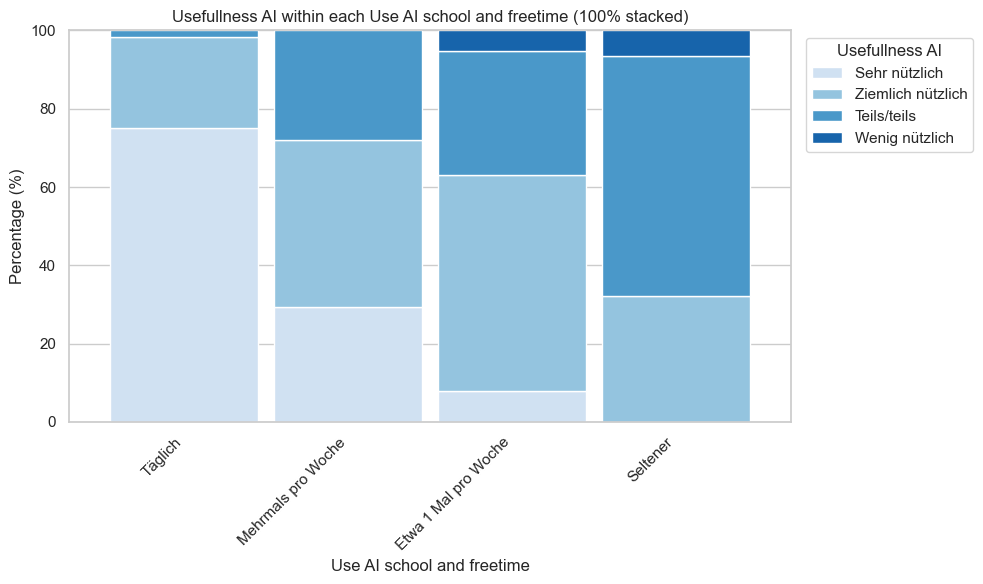


🔍 Chi²-test: Use AI school and freetime × Concerns AI | chi²=22.566, df=8, p=0.0040 → ✅ significant

📊 Concerns AI within each Use AI school and freetime (rows sum to 100%)
Counts:
 Concerns AI                 Ja  Nein  Ich habe darüber noch nie nachgedacht.
Use AI school and freetime                                                  
Täglich                     18    31                                       7
Mehrmals pro Woche          32    23                                      13
Etwa 1 Mal pro Woche        12    10                                      16
Seltener                    14     6                                      11
Nie                          3     4                                       3

Percent:
 Concerns AI                   Ja  Nein  Ich habe darüber noch nie nachgedacht.
Use AI school and freetime                                                    
Täglich                     32.1  55.4                                    12.5
Mehrmals pro Woche          47

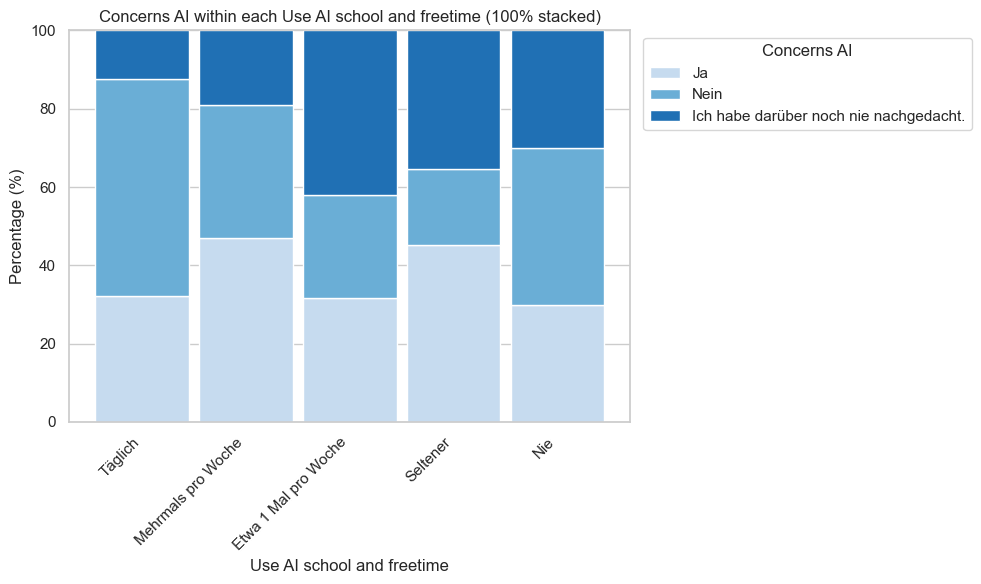


🔍 Chi²-test: Use AI school and freetime × Most used subjects | chi²=63.406, df=56, p=0.2316 → ❌ not significant

📊 Most used subjects within each Use AI school and freetime (rows sum to 100%)
Counts:
 Most used subjects          Berufsorientierung  Biologie  Chemie  Deutsch  \
Use AI school and freetime                                                  
Täglich                                      0        17      11       13   
Mehrmals pro Woche                           0        13      14       21   
Etwa 1 Mal pro Woche                         1         3       3       13   
Seltener                                     2         3       5       10   
Nie                                          0         0       0        1   

Most used subjects          Englisch  Französisch  Geografie  Geschichte  \
Use AI school and freetime                                                 
Täglich                            8           16         13          28   
Mehrmals pro Woche            

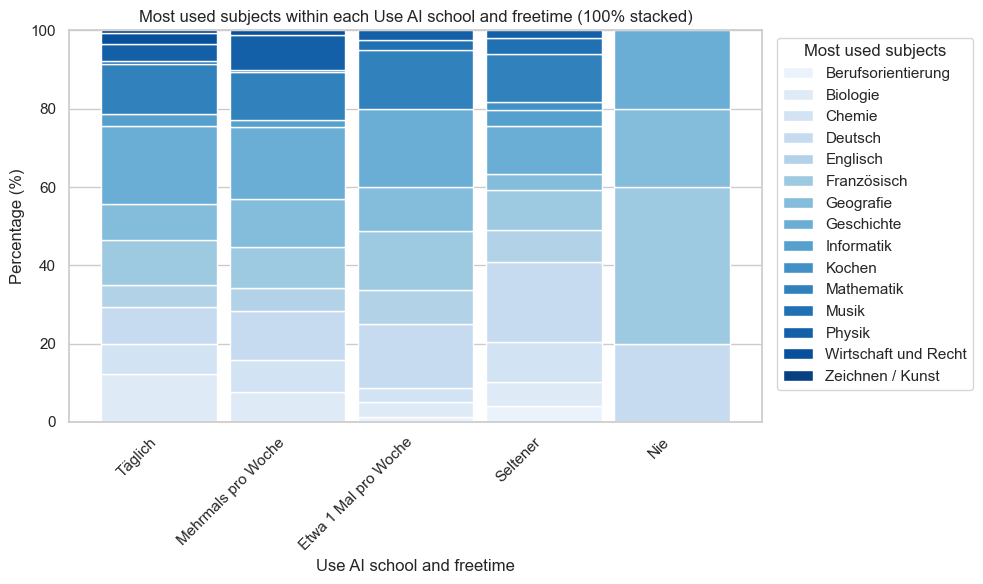


🔍 Chi²-test: Use AI school and freetime × Reliability AI | chi²=64.640, df=20, p=0.0000 → ✅ significant

📊 Reliability AI within each Use AI school and freetime (rows sum to 100%)
Counts:
 Reliability AI              Sehr verlässlich  Eher verlässlich  Teils/teils  \
Use AI school and freetime                                                    
Täglich                                    6                31           17   
Mehrmals pro Woche                         3                35           24   
Etwa 1 Mal pro Woche                       1                12           20   
Seltener                                   0                 4           20   
Nie                                        0                 2            5   

Reliability AI              Wenig verlässlich  Gar nicht verlässlich  \
Use AI school and freetime                                             
Täglich                                     2                      0   
Mehrmals pro Woche                      

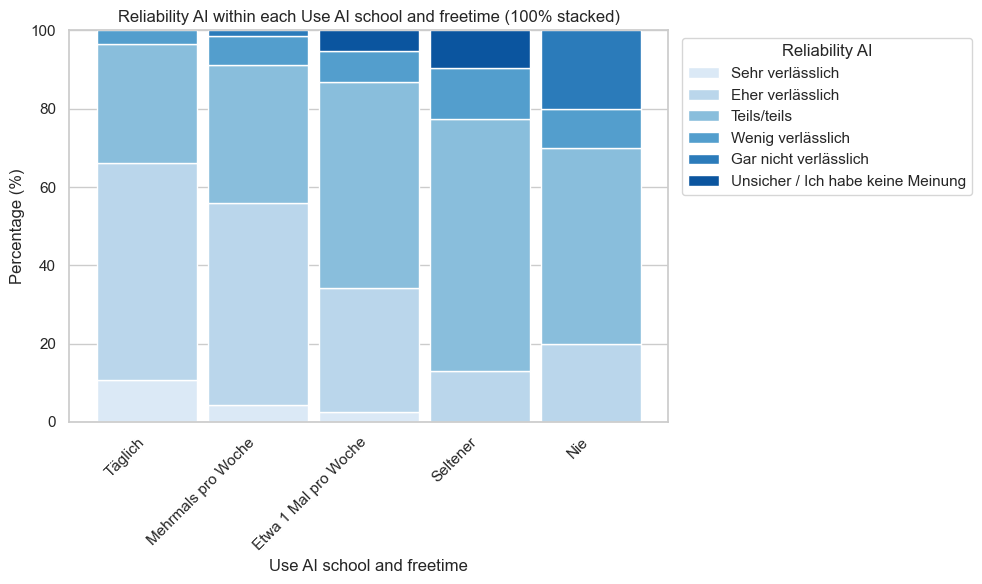


🔍 Chi²-test: Use AI school and freetime × Mates using AI | chi²=58.442, df=12, p=0.0000 → ✅ significant

📊 Mates using AI within each Use AI school and freetime (rows sum to 100%)
Counts:
 Mates using AI              Selten  Manchmal  Oft  Immer
Use AI school and freetime                              
Täglich                          0         1   36     18
Mehrmals pro Woche               0        11   47      9
Etwa 1 Mal pro Woche             1        16   18      3
Seltener                         2        12   15      2
Nie                              2         3    5      0

Percent:
 Mates using AI              Selten  Manchmal   Oft  Immer
Use AI school and freetime                               
Täglich                        0.0       1.8  65.5   32.7
Mehrmals pro Woche             0.0      16.4  70.1   13.4
Etwa 1 Mal pro Woche           2.6      42.1  47.4    7.9
Seltener                       6.5      38.7  48.4    6.5
Nie                           20.0      30.0  50.0  

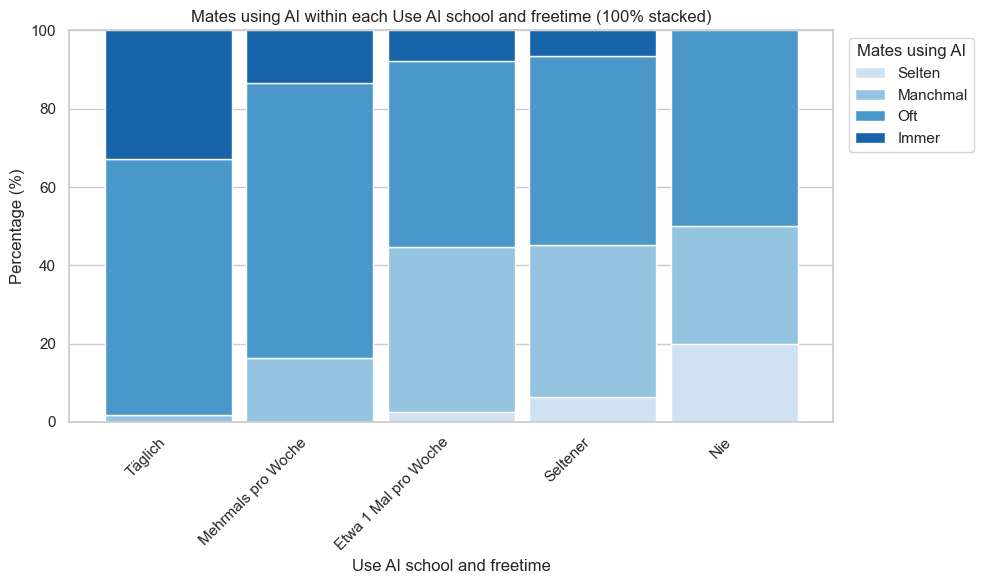


🔍 Chi²-test: Use AI school and freetime × Help of AI | chi²=47.755, df=12, p=0.0000 → ✅ significant

📊 Help of AI within each Use AI school and freetime (rows sum to 100%)
Counts:
 Help of AI                  Sehr gut  Eher gut  Neutral  Eher schlecht
Use AI school and freetime                                            
Täglich                           17        26        8              1
Mehrmals pro Woche                 9        39       14              3
Etwa 1 Mal pro Woche               3        16       15              1
Seltener                           1         8       12              6
Nie                                2         0        0              1

Percent:
 Help of AI                  Sehr gut  Eher gut  Neutral  Eher schlecht
Use AI school and freetime                                            
Täglich                         32.7      50.0     15.4            1.9
Mehrmals pro Woche              13.8      60.0     21.5            4.6
Etwa 1 Mal pro Woche      

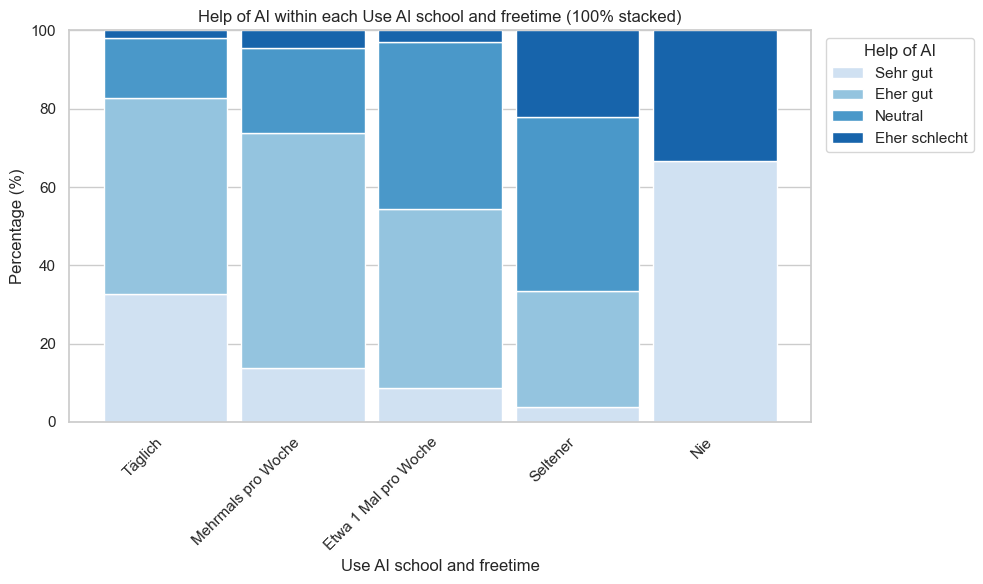


🔍 Chi²-test: Used AI × Reliability AI | chi²=89.047, df=75, p=0.1280 → ❌ not significant

📊 Reliability AI within each Used AI (rows sum to 100%)
Counts:
 Reliability AI           Sehr verlässlich  Eher verlässlich  Teils/teils  \
Used AI                                                                    
Aria (Opera Browser AI)                 0                 1            0   
Chai AI                                 1                 0            0   
Character.ai                            1                 0            0   
ChatGPT                                 9                79           76   
Claude AI                               1                 1            2   
Deep Seek                               2                11            8   
Duck.ai                                 0                 0            1   
Gamma AI                                0                 1            0   
Gemini (Google)                         1                19           14   
GitHub C

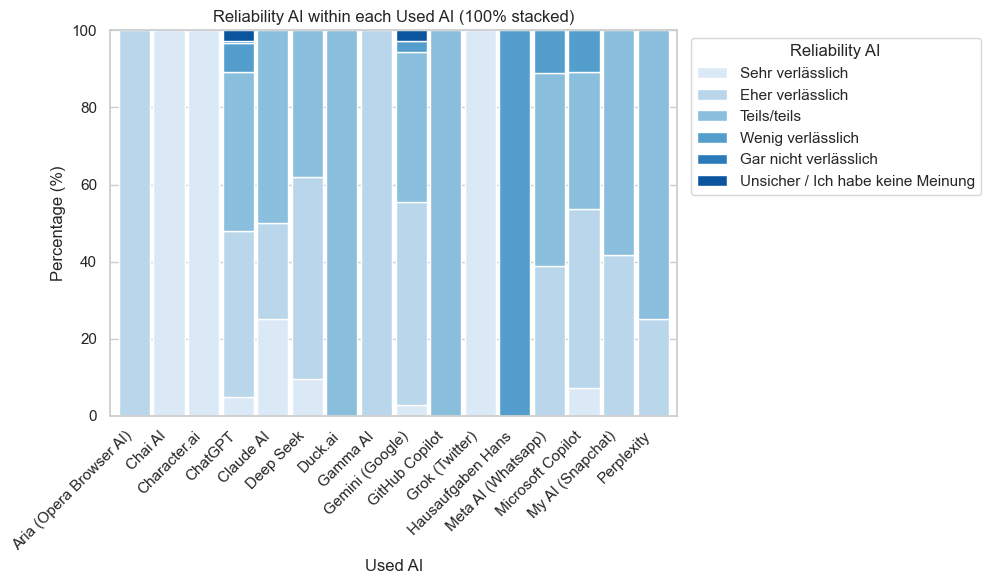


🔍 Chi²-test: Used AI × Concerns AI | chi²=34.699, df=30, p=0.2537 → ❌ not significant

📊 Concerns AI within each Used AI (rows sum to 100%)
Counts:
 Concerns AI              Ja  Nein  Ich habe darüber noch nie nachgedacht.
Used AI                                                                  
Aria (Opera Browser AI)   1     0                                       0
Chai AI                   0     1                                       0
Character.ai              0     1                                       0
ChatGPT                  69    68                                      47
Claude AI                 2     2                                       0
Deep Seek                 7    11                                       3
Duck.ai                   1     0                                       0
Gamma AI                  0     1                                       0
Gemini (Google)          11    17                                       8
GitHub Copilot            2     0   

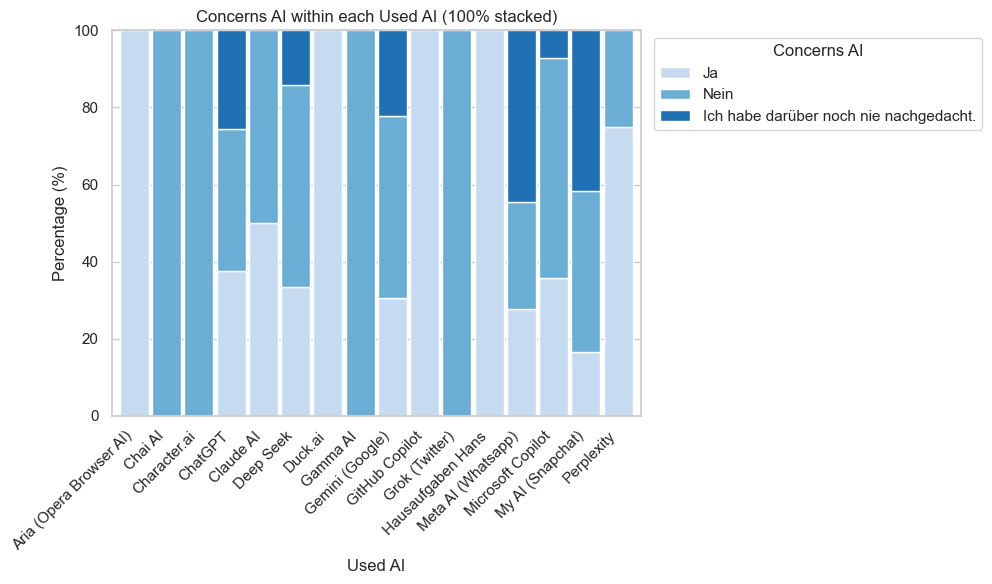


🔍 Chi²-test: Understanding AI × Deal with AI | chi²=73.643, df=16, p=0.0000 → ✅ significant

📊 Deal with AI within each Understanding AI (rows sum to 100%)
Counts:
 Deal with AI             Sehr gut  Eher gut  Weder gut noch schlecht  \
Understanding AI                                                       
Sehr gut                       16         2                        0   
Eher gut                       15        29                       14   
Weder gut noch schlecht        14        48                       22   
Eher wenig                      1        11                       16   
Gar nicht                       1         5                        1   

Deal with AI             Eher schlecht  Schlecht  
Understanding AI                                  
Sehr gut                             0         0  
Eher gut                             0         0  
Weder gut noch schlecht              4         0  
Eher wenig                           3         1  
Gar nicht              

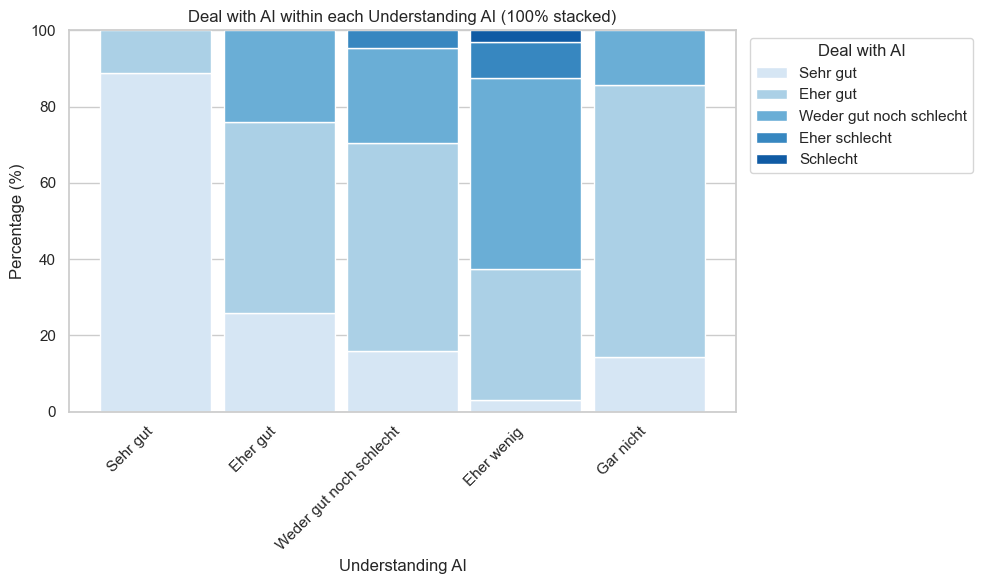


🔍 Chi²-test: Understanding AI × True_False_Score | chi²=29.400, df=24, p=0.2054 → ❌ not significant

📊 True_False_Score within each Understanding AI (rows sum to 100%)
Counts:
 True_False_Score         0   1   2   3   4   5   6
Understanding AI                                  
Sehr gut                 1   1   1   5   6   2   2
Eher gut                 3   4   6   8  17   9  11
Weder gut noch schlecht  2  10  14  13  14  21  14
Eher wenig               1   3   6   8   3   7   4
Gar nicht                2   0   0   0   2   2   1

Percent:
 True_False_Score            0     1     2     3     4     5     6
Understanding AI                                                 
Sehr gut                  5.6   5.6   5.6  27.8  33.3  11.1  11.1
Eher gut                  5.2   6.9  10.3  13.8  29.3  15.5  19.0
Weder gut noch schlecht   2.3  11.4  15.9  14.8  15.9  23.9  15.9
Eher wenig                3.1   9.4  18.8  25.0   9.4  21.9  12.5
Gar nicht                28.6   0.0   0.0   0.0  28.6  28.

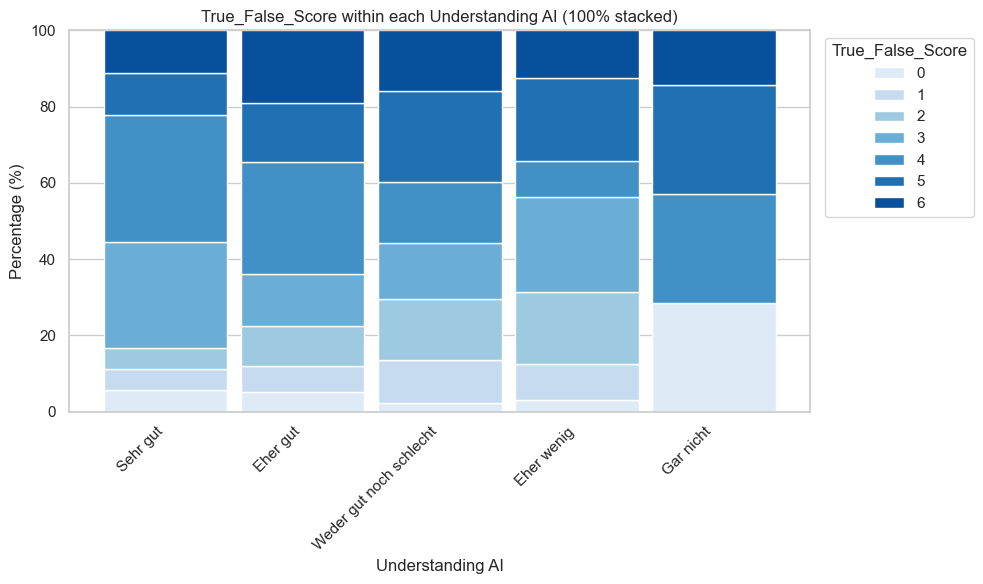


🔍 Chi²-test: Understanding AI × Internet Understanding (Grouped) | chi²=33.670, df=16, p=0.0060 → ✅ significant

📊 Internet Understanding (Grouped) within each Understanding AI (rows sum to 100%)
Counts:
 Internet Understanding (Grouped)  Sehr schlechtes Verständnis  \
Understanding AI                                                
Sehr gut                                                    3   
Eher gut                                                    8   
Weder gut noch schlecht                                    22   
Eher wenig                                                 10   
Gar nicht                                                   2   

Internet Understanding (Grouped)  Schlechtes Verständnis  \
Understanding AI                                           
Sehr gut                                               2   
Eher gut                                              13   
Weder gut noch schlecht                               23   
Eher wenig                            

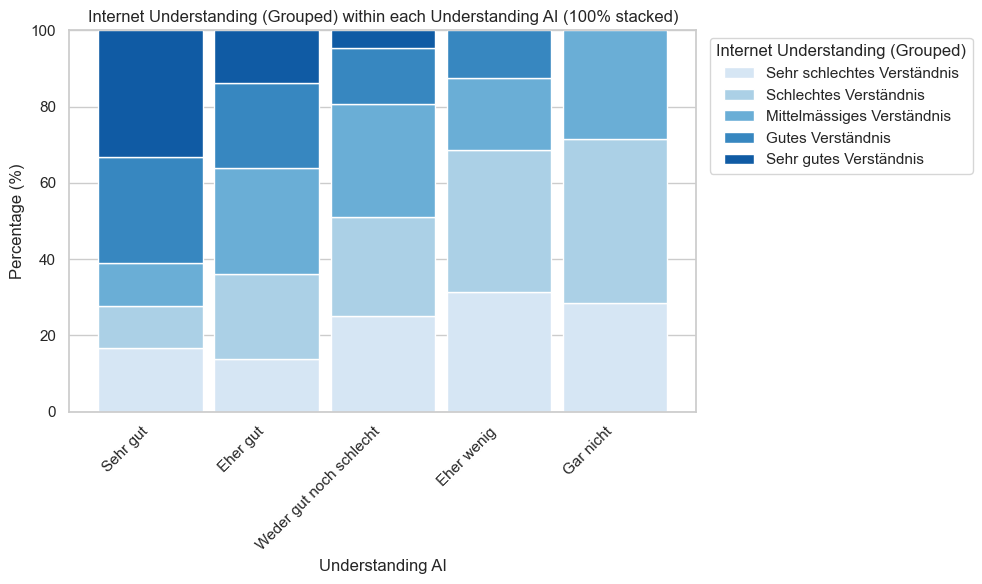


🔍 Chi²-test: Internet Understanding (Grouped) × True_False_Score | chi²=65.427, df=24, p=0.0000 → ✅ significant

📊 True_False_Score within each Internet Understanding (Grouped) (rows sum to 100%)
Counts:
 True_False_Score                  0   1   2   3   4   5   6
Internet Understanding (Grouped)                           
Sehr schlechtes Verständnis       6  12   8   7   5   5   2
Schlechtes Verständnis            2   3  12   8  10  14   4
Mittelmässiges Verständnis        1   2   5  11   9   9  15
Gutes Verständnis                 0   1   2   5  11   8   8
Sehr gutes Verständnis            0   0   0   3   7   5   3

Percent:
 True_False_Score                     0     1     2     3     4     5     6
Internet Understanding (Grouped)                                          
Sehr schlechtes Verständnis       13.3  26.7  17.8  15.6  11.1  11.1   4.4
Schlechtes Verständnis             3.8   5.7  22.6  15.1  18.9  26.4   7.5
Mittelmässiges Verständnis         1.9   3.8   9.6  21.2  17.3 

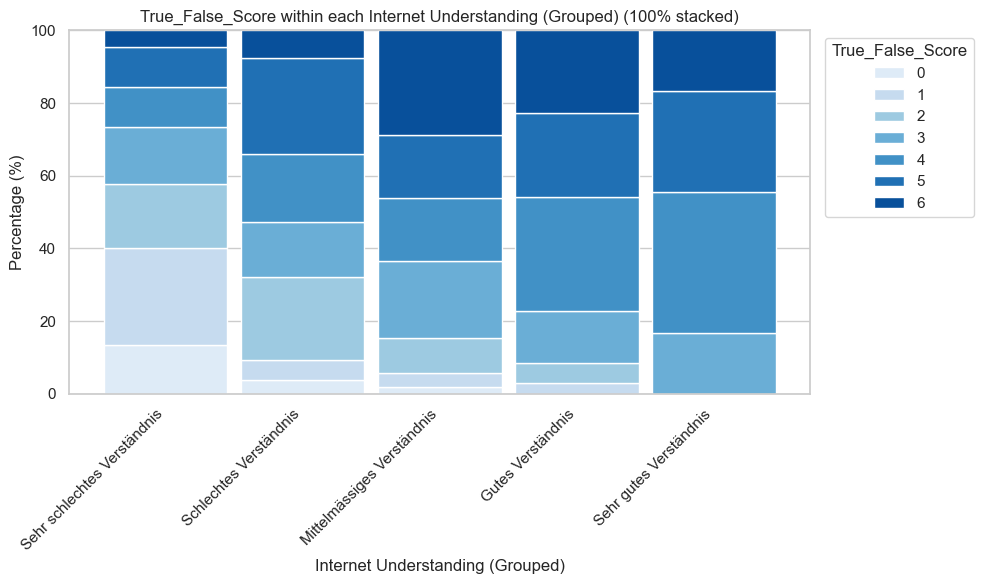


🔍 Chi²-test: Reliability AI × Teachers preparing lessons | chi²=43.970, df=20, p=0.0015 → ✅ significant

📊 Teachers preparing lessons within each Reliability AI (rows sum to 100%)
Counts:
 Teachers preparing lessons         Stört mich sehr  Stört mich ein wenig  \
Reliability AI                                                             
Sehr verlässlich                                 2                     0   
Eher verlässlich                                 6                    17   
Teils/teils                                      8                    26   
Wenig verlässlich                                3                     5   
Gar nicht verlässlich                            3                     0   
Unsicher / Ich habe keine Meinung                0                     0   

Teachers preparing lessons         Neutral / Mir egal  Finde ich gut  \
Reliability AI                                                         
Sehr verlässlich                                    6    

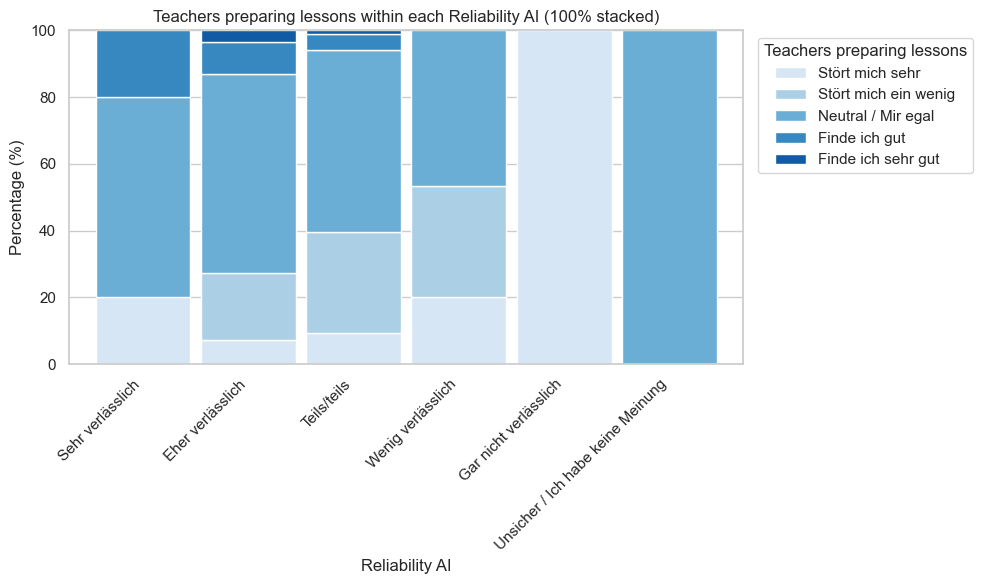


🔍 Chi²-test: Reliability AI × Teachers giving grades | chi²=46.164, df=20, p=0.0008 → ✅ significant

📊 Teachers giving grades within each Reliability AI (rows sum to 100%)
Counts:
 Teachers giving grades             Stört mich sehr  Stört mich ein wenig  \
Reliability AI                                                             
Sehr verlässlich                                 3                     2   
Eher verlässlich                                34                    26   
Teils/teils                                     56                    19   
Wenig verlässlich                               11                     3   
Gar nicht verlässlich                            3                     0   
Unsicher / Ich habe keine Meinung                1                     1   

Teachers giving grades             Neutral / Mir egal  Finde ich gut  \
Reliability AI                                                         
Sehr verlässlich                                    2            

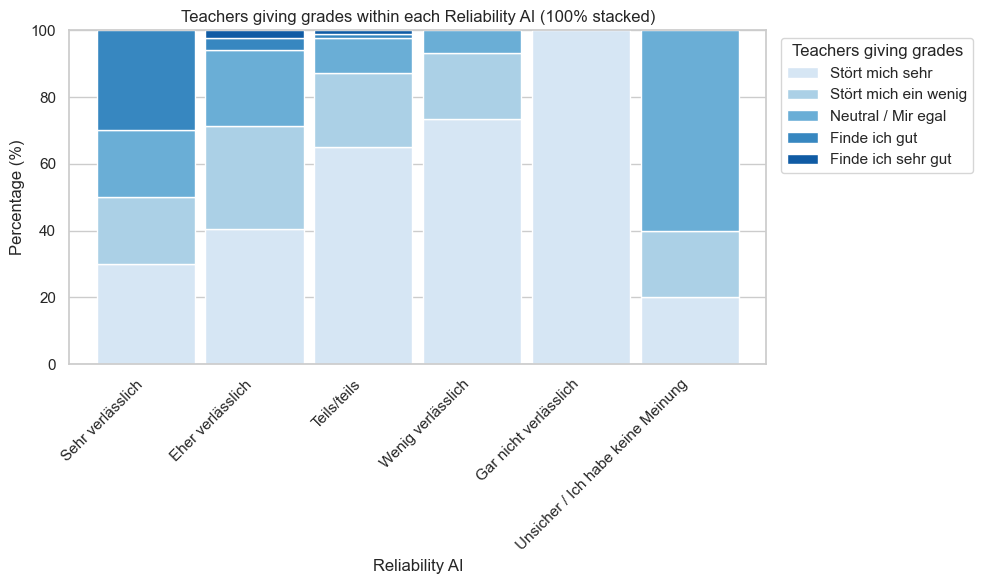

❌ Failed for Frequency of use AI_school x Help of AI: "['Frequency of use AI_school'] not in index"


In [2]:
# ---------------- Notebook 04: AI x AI (stacked 100% bars + Chi-square) ----------------
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- Imports from repo ---
sys.path.append(os.path.abspath(".."))
from answer_categories import question_orders
from lists import (
    comparison_pairs_by_AI_questions,   
    multiple_choice_questions,          
)

try:
    from lists import cross_tab_titles_and_colors_ai
except Exception:
    cross_tab_titles_and_colors_ai = {}

from Helper_funtions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding
)

# --- Load data ---
file_path = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# --- Pre-cleaning / scores (keep behavior consistent with other notebooks) ---
# limit Most used subjects to 3 with fixed seed
df = clean_up_subjects(df, "Most used subjects")

# score columns that are referenced in pairs
df = calculate_true_false_score(df)
df = calculate_Internet_terms_understanding_score(df)
df = group_internet_understanding(df)

# --- Helper: align two columns on the same rows and explode when needed ---
def build_pair_dataframe(df_in: pd.DataFrame, left: str, right: str) -> pd.DataFrame:
    """
    Returns a DataFrame with two cleaned columns [left, right], where:
      - multiple-choice columns are split on ',' and exploded
      - empty/whitespace-only values are removed
      - both columns come from the same row slice to keep alignment
    """
    left_is_multi  = left  in multiple_choice_questions
    right_is_multi = right in multiple_choice_questions

    tmp = df_in[[left, right]].dropna().copy()

    if left_is_multi:
        tmp[left] = tmp[left].astype(str).str.split(",")
    else:
        tmp[left] = tmp[left].astype(str).str.strip()

    if right_is_multi:
        tmp[right] = tmp[right].astype(str).str.split(",")
    else:
        tmp[right] = tmp[right].astype(str).str.strip()

    # explode whichever needs exploding (order matters: explode one, then the other)
    if left_is_multi:
        tmp = tmp.explode(left)
    if right_is_multi:
        tmp = tmp.explode(right)

    # strip again (post-explode) and drop truly empty
    tmp[left]  = tmp[left].astype(str).str.strip()
    tmp[right] = tmp[right].astype(str).str.strip()
    tmp = tmp[(tmp[left] != "") & (tmp[right] != "")]

    return tmp

# --- Helper: apply ordering with question_orders or numeric ---
def order_rows_cols(ct: pd.DataFrame, rows_key: str, cols_key: str) -> pd.DataFrame:
    # columns (answers of "right" question)
    if cols_key in question_orders:
        col_order = [v for v in question_orders[cols_key] if v in ct.columns]
        remaining_cols = [v for v in ct.columns if v not in col_order]
        ct = ct[col_order + remaining_cols]
    else:
        # numeric fallback for columns
        try:
            _ = pd.to_numeric(ct.columns)
            ct = ct[sorted(ct.columns, key=lambda x: float(x))]
        except Exception:
            pass

    # rows (answers of "left" question)
    if rows_key in question_orders:
        row_order = [v for v in question_orders[rows_key] if v in ct.index]
        remaining_rows = [v for v in ct.index if v not in row_order]
        ct = ct.reindex(row_order + remaining_rows)
    else:
        # numeric fallback for rows
        try:
            ct.index = pd.to_numeric(ct.index)
            ct = ct.sort_index()
        except Exception:
            pass

    return ct

# --- Plotting defaults ---
sns.set(style="whitegrid")

# --- Main loop: for each AI base question, compare to each AI question ---
for base_question, compare_list in comparison_pairs_by_AI_questions.items():
    for compare_question in compare_list:
        try:
            # Build pair-wise dataset (handles single/multiple and alignment)
            data = build_pair_dataframe(df, base_question, compare_question)
            if data.empty:
                print(f"⚠️ No overlapping data for '{base_question}' x '{compare_question}'. Skipping.")
                continue

            # Crosstab: rows = base question categories, cols = compare question categories
            ct = pd.crosstab(data[base_question], data[compare_question])

            # Fold duplicates (rare: if hidden whitespace produced duplicate labels)
            if not ct.columns.is_unique:
                ct = ct.T.groupby(level=0).sum().T
            if not ct.index.is_unique:
                ct = ct.groupby(level=0).sum()

            # Apply predefined ordering (or numeric as fallback)
            ct = order_rows_cols(ct, rows_key=base_question, cols_key=compare_question)

            # Normalize each row (each bar = 100%)
            ct_percent = (ct.div(ct.sum(axis=1), axis=0) * 100).fillna(0)

            # ---- Chi-square test on counts (NOT on percentages) ----
            # Filter out rows with zero total (rare)
            ct_for_test = ct.loc[ct.sum(axis=1) > 0]
            significant = None
            if ct_for_test.shape[0] >= 2 and ct_for_test.shape[1] >= 2:
                chi2, p, dof, expected = chi2_contingency(ct_for_test)
                significant = (p < 0.05)
                print(f"\n🔍 Chi²-test: {base_question} × {compare_question} | chi²={chi2:.3f}, df={dof}, p={p:.4f} → "
                      f"{'✅ significant' if significant else '❌ not significant'}")
            else:
                print(f"\nℹ️ Chi²-test skipped for '{base_question} × {compare_question}' (table too small).")

            # ---- Tabular printout (Counts & %) ----
            print(f"\n📊 {compare_question} within each {base_question} (rows sum to 100%)")
            print("Counts:\n", ct)
            print("\nPercent:\n", ct_percent.round(1))

            # ---- Plot: stacked 100% bar (X = base_question categories, stacks = compare_question answers) ----
            title_and_colors = cross_tab_titles_and_colors_ai.get(
                (base_question, compare_question),
                [f"{compare_question} within each {base_question} (100% stacked)"]
            )
            plot_title = title_and_colors[0]

            blues_palette = sns.color_palette("Blues", n_colors=5)

            ax = None
            if len(title_and_colors) > 1:
                # explicit colors supplied
                colors = title_and_colors[1:]
                ax = ct_percent.plot(kind="bar", stacked=True, figsize=(10, 6), color=colors, width=0.9)
            else:
                # default palette
                ax = ct_percent.plot(kind="bar", stacked=True, figsize=(10, 6), color=sns.color_palette("Blues", n_colors=len(ct_percent.columns)), width=0.9)

            ax.set_title(plot_title)
            ax.set_ylabel("Percentage (%)")
            ax.set_xlabel(base_question)
            ax.set_ylim(0, 100)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title=compare_question, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed for {base_question} x {compare_question}: {e}")
